<a href="https://www.kaggle.com/code/enricofindley/corn-leaf-disease-classification-with-fcm-lstm?scriptVersionId=140531659" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# README
#### This is my thesis project, if some of you need to use a portion or all of my code feel free to copy it but please cite my thesis <a href="http://repo.darmajaya.ac.id/11576/">here</a>

# Installing Dependencies

In [1]:
# install split folders for splitting image data into train,val, and test.
%pip install split-folders
%pip install scikit-fuzzy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import os
import cv2
import skfuzzy as fuzz
import pandas as pd 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import splitfolders
import shutil
from keras.utils import np_utils
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 15.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=07cf47dcf7c56198fed8115e8297e6fe77dac59f9be7071aa02b3a514e51fadc
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Image Dataset Splitting

In this part we are going to do:
* Create folder 'data' which later contain raw splitted dataset and segmented dataset
* Using <code>splitfolders</code> library to handle splitting the image file
* Adding oversampling to <code>splitfolders</code> so the dataset will become balanced

In [7]:
def createFolder(folder_path):
    # if folder 'data' not exist it make the folder 'data'
    if not os.path.exists(folder_path):
       os.makedirs(folder_path)
    # else if folder 'data' not exist then it will delete it then make the folder 'data'
    else:
      # Deleting an non-empty folder
      shutil.rmtree(folder_path, ignore_errors=True)
      print("Deleted '%s' directory successfully" % folder_path)

      os.makedirs(folder_path)

In [8]:
file_path='/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Corn'
splitted_folder='data'
createFolder(splitted_folder)


# make splitfolders function to split dataset
def train_test_valid(images_folder=file_path,splitted_folder=splitted_folder):
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.fixed(input_folder,output_folder, seed = 1337, fixed = (100,100), oversample=True, group_prefix = None)

# run function train_test_valid()
train_test_valid()

Deleted 'data' directory successfully


Copying files: 3852 files [00:12, 312.77 files/s]
Oversampling: 4 classes [00:00, 24.65 classes/s]


# Declaring Global Variables

In [10]:
CATEGORIES = ["Corn___Common_Rust","Corn___Gray_Leaf_Spot","Corn___Healthy", "Corn___Northern_Leaf_Blight"]
IMG_SIZE = 128

TRAIN_DATADIR = "/kaggle/working/data/train"
VALIDATION_DATADIR = "/kaggle/working/data/val"
TEST_DATADIR = "/kaggle/working/data/test"

SEG_TRAIN_DATADIR = "/kaggle/working/data/segmented/train"
SEG_VALIDATION_DATADIR = "/kaggle/working/data/segmented/val"
SEG_TEST_DATADIR = "/kaggle/working/data/segmented/test"
clusters = [2]

createFolder(SEG_TRAIN_DATADIR)
createFolder(SEG_VALIDATION_DATADIR)
createFolder(SEG_TEST_DATADIR)

Deleted '/kaggle/working/data/segmented/train' directory successfully
Deleted '/kaggle/working/data/segmented/val' directory successfully
Deleted '/kaggle/working/data/segmented/test' directory successfully


# Fuzzy C-Means (FCM) Image Segmentation

First algorithm used to do image segmentation is Fuzzy C-Means (FCM), we are going to do:
* Declaring function to change color of segmented region from FCM algorithm
* Convert image into grayscale then resize it to 128x128 and reshape it into 2 dimensional array as <code>uint8</code> type
* Segmenting the image using FCM then convert it to binary image and highlight the segmented area with alpha blending
* Put segmented image data into an array before giving it to LSTM model

In [12]:
# function to change color of segmented region from FCM algorithm
def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

# segmenting image with FCM
def segmentImage(data_path, result_path):
    for category in CATEGORIES:  
        index=0
        path = os.path.join(data_path,category)  # create path to image
        seg_path=os.path.join(result_path,category)  # create path to image
        class_num = CATEGORIES.index(category)  # get the classification
        os.makedirs(seg_path)
        for img in os.listdir(path):  # iterate over each image 
            img_input = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
            img_resized= cv2.resize(img_input, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
            gray_img = img_resized.reshape(( img_resized.shape[0] *  img_resized.shape[1], 1))          
            img = np.reshape(gray_img, (IMG_SIZE,IMG_SIZE,1)).astype(np.uint8)
            shape = np.shape(img)

            for i,cluster in enumerate(clusters):                  
                # Fuzzy C Means
                    
                cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(gray_img.T, cluster, 2, error=0.00001, maxiter=100, init=None,seed=42)  
                new_img = change_color_fuzzycmeans(u,cntr)
                    
                fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)  
                ret, seg_img = cv2.threshold(fuzzy_img,np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)

                # Add the color mask to the original image using alpha blending
                alpha = 0.6
                result = cv2.addWeighted(img, alpha, seg_img, 1-alpha, 0)     
                
            index=index+1
            cv2.imwrite(os.path.join(seg_path , 'segmented'+str(index)+'.png'), result)

# run function segmentImage() for all dataset part
#segmentImage(TRAIN_DATADIR, SEG_TRAIN_DATADIR)
segmentImage(VALIDATION_DATADIR, SEG_VALIDATION_DATADIR)
segmentImage(TEST_DATADIR, SEG_TEST_DATADIR)

Creating segmented image data for training, validation, and testing with LSTM model.

In [27]:
training_data = []
val_data = []
test_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(SEG_TRAIN_DATADIR,category)  # create path to image
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                training_data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))


def create_validation_data():
    for category in CATEGORIES:  #

        path = os.path.join(SEG_VALIDATION_DATADIR,category)  
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                val_data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

def create_test_data():
    for category in CATEGORIES:  

        path = os.path.join(SEG_TEST_DATADIR,category)  # create path to image
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                test_data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
            
create_training_data()
create_validation_data()
create_test_data()

100%|██████████| 100/100 [00:00<00:00, 3675.18it/s]


# Data Preprocessing before Training

In [28]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for features,label in training_data:
    x_train.append(features)
    y_train.append(label)
for features,label in val_data:
    x_val.append(features)
    y_val.append(label)
for features,label in test_data:
    x_test.append(features)
    y_test.append(label)

x_train = (np.array(x_train)) 
x_val = (np.array(x_val))
x_test = (np.array(x_test))

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

x_train = (x_train.astype('float32'))/255
x_val = (x_val.astype('float32'))/255
x_test = (x_test.astype('float32'))/255

# Model Training and Evaluation with K-Fold Cross Validation

In [29]:
# Model configuration
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)
batch_size = 128
no_epochs = 50
verbosity = 1
num_folds = 10


# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((x_train, x_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(inputs, targets):

  # Define the model architecture
  model = keras.Sequential()
  model.add(keras.Input(shape=(128,128)))
  model.add(keras.layers.LSTM(192))
  model.add(keras.layers.Dense(4, activation='softmax'))
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=1e-3),metrics = ['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              validation_data=(inputs[val], targets[val]),          
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(inputs[val], targets[val], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  model.save(str(fold_no)+'foldmodel.h5')
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
31/31 [==============================] - 3s 39ms/step - loss: 1.0753 - accuracy: 0.5172 - val_loss: 0.9305 - val_accuracy: 0.5492
Epoch 2/50
31/31 [==============================] - 1s 19ms/step - loss: 0.8347 - accuracy: 0.6133 - val_loss: 0.9106 - val_accuracy: 0.6110
Epoch 3/50
31/31 [==============================] - 1s 19ms/step - loss: 0.7946 - accuracy: 0.6197 - val_loss: 0.7665 - val_accuracy: 0.6728
Epoch 4/50
31/31 [==============================] - 1s 19ms/step - loss: 0.8056 - accuracy: 0.6177 - val_loss: 0.8038 - val_accuracy: 0.6430
Epoch 5/50
31/31 [==============================] - 1s 19ms/step - loss: 0.7896 - accuracy: 0.6367 - val_loss: 0.8189 - val_accuracy: 0.6270
Epoch 6/50
31/31 [==============================] - 1s 20ms/step - loss: 0.8535 - accuracy: 0.6177 - val_loss: 0.8329 - val_accuracy: 0.6064
Epoch 7/50
31/31 [==============================] - 1s 19

Print score per fold

In [30]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5107450485229492 - Accuracy: 86.27002239227295%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.43797731399536133 - Accuracy: 84.89702343940735%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.37511250376701355 - Accuracy: 87.41418719291687%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5324150919914246 - Accuracy: 84.43936109542847%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4656757116317749 - Accuracy: 85.12585759162903%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.4767717719078064 - Accuracy: 85.81235408782959%
----------------------------------------------------------------------

Defining helper function for testing

In [31]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n ({})".format(CATEGORIES[predicted_label],
                                100*np.max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Model Testing

Testing here by choosing the highest model accuracy

In [32]:
predict_model = keras.models.load_model('3foldmodel.h5')
predictions = predict_model.predict(x_test)

13/13 [==============================] - 1s 8ms/step


Print 1 prediction

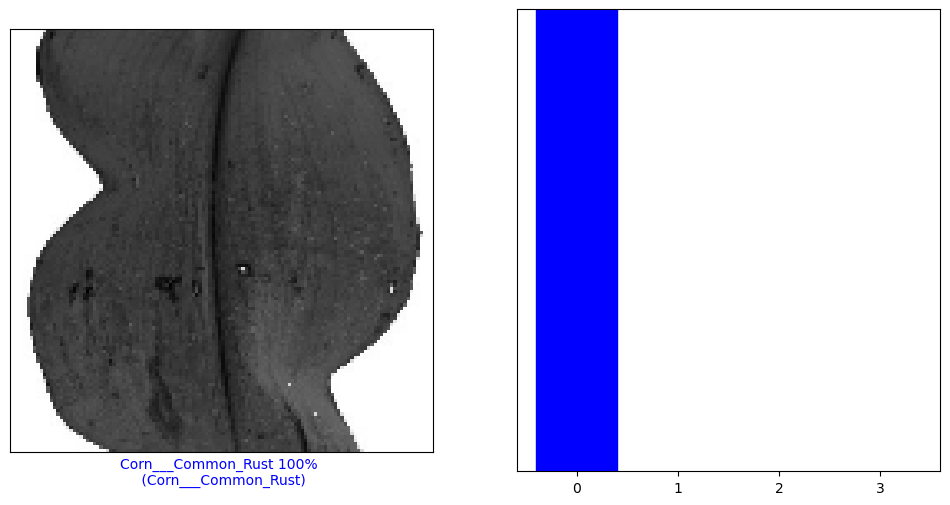

In [33]:
TEST_DATA_INDEX = 0
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_image(TEST_DATA_INDEX, predictions[TEST_DATA_INDEX], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(TEST_DATA_INDEX, predictions[TEST_DATA_INDEX],  y_test)
plt.show()

Print 40 random prediction

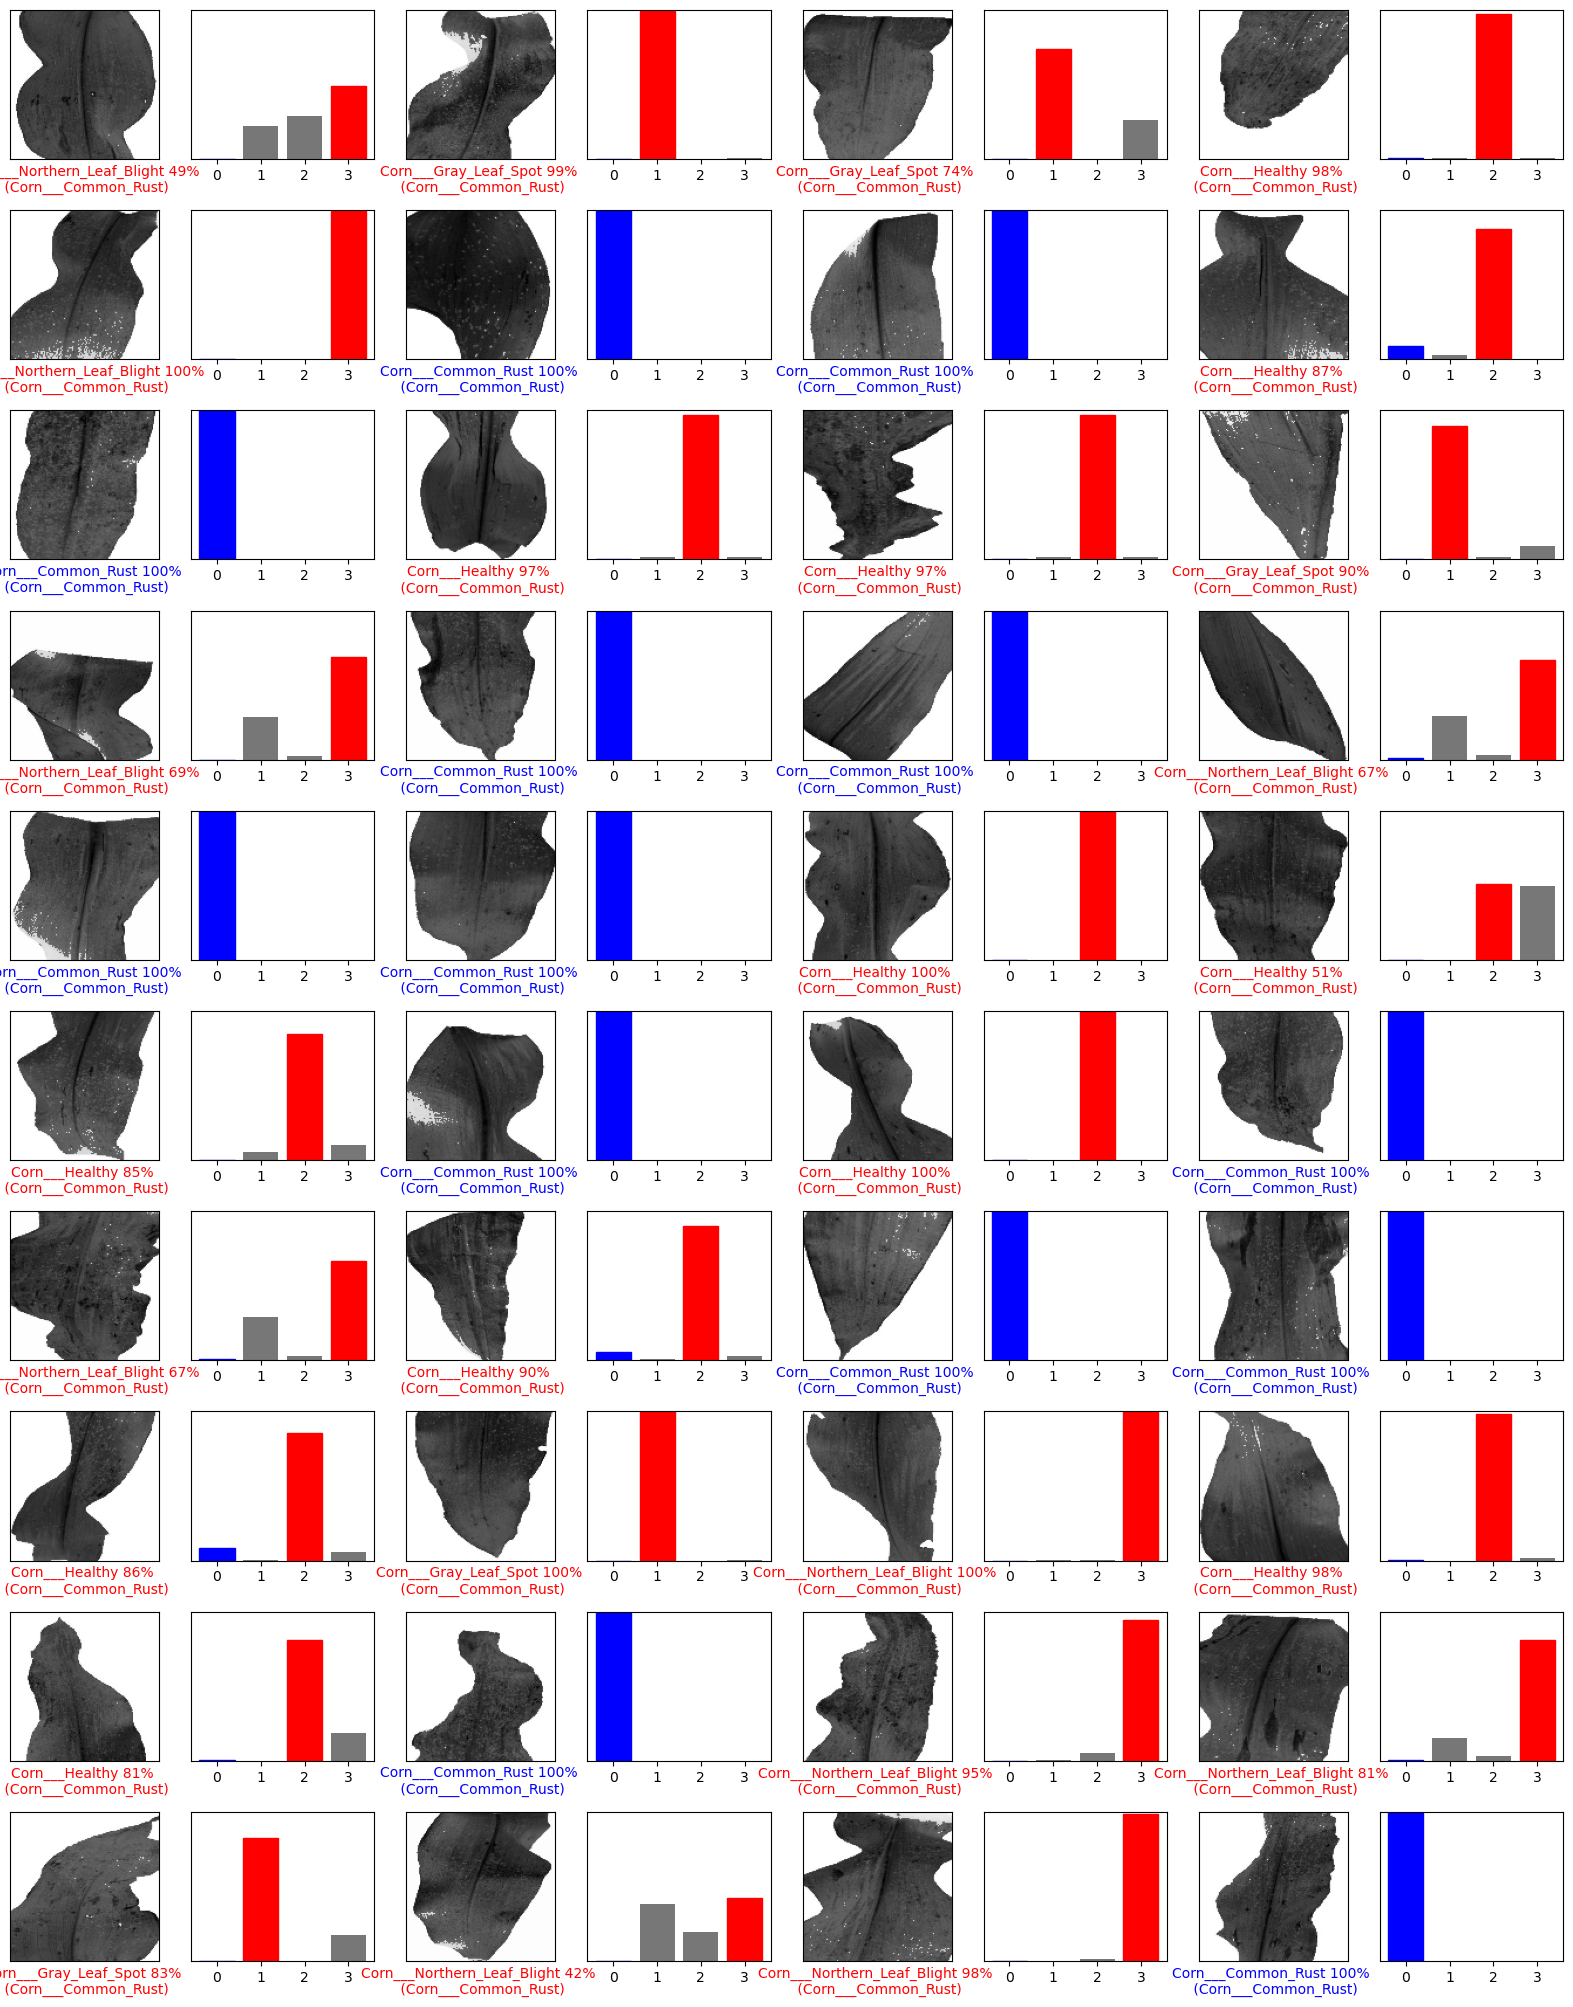

In [36]:
import random

num_rows = 100
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(0,40):
  randomIndex = random.randrange(0, 400, 3)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[randomIndex], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[randomIndex], y_test)
plt.tight_layout()
plt.show()